In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.chdir('..')

In [3]:
import pickle
import itertools
import glob

import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import configs
from utils import utils
from utils import laion_utils as laionu
from utils import wordnet_utils as wnu
from utils.calc_utils import calc_recall_per_y, calc_equi_acc, combine_recalls, z
from core.ilsvrc_predictors import all_model_names_1k, all_model_names_pt21k_ft1k, all_model_names_21k
from core.queries import QueryType

[nltk_data] Downloading package wordnet to /Users/alishri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/alishri/Desktop/Berkeley/research/hardt/projects/why imagenet looks unlike laion/codes/eval-on-laion/laionvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Settings

## Filtering

In [4]:
q_type = QueryType.NAME_DEF
q_key = 'wnid'
text_encoder_ver = configs.CLIPConfig.DEFAULT_VERSION  # or 'all-mpnet-base-v2'

query_col = q_type + '_' + q_key
text_query_sim_col = f'text_to_{query_col}_similarity_{text_encoder_ver}'

print(text_query_sim_col)

text_to_name_def_wnid_similarity_clip-vit-base-patch32


## Path

### LAIONet

In [5]:
laion_path = 'laion400m'
laion_until_part = 31

laionet_prefix = configs.NamingConfig.append_filtered(configs.NamingConfig.SUBSET_SM_PREFIX, text_query_sim_col)

do_skim = False  # Skimmed version of LAIONet only keeps top 50 matches for each class
if do_skim:
    laionet_prefix = configs.NamingConfig.append_skimmed(laionet_prefix)

laionet_file_name = laionet_prefix + '_' + laionu.get_laion_subset_file_name(0, laion_until_part)

print(laionet_file_name)

# Labels
laionet_labels_path = os.path.join(laion_path, 'processed', 'ilsvrc_labels')
laionet_labels_file_name = f'wnid2laionindices({laionet_prefix}).pkl'

subset_sm_filt(text_to_name_def_wnid_similarity_clip-vit-base-patch32)_part-00000-to-part00031-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet


### ILSVRC val

In [6]:
ilsvrc_path = 'ilsvrc2012'

ilsvrc_val_prefix = 'ILSVRC2012_val'

ilsvrc_val_file_name = ilsvrc_val_prefix + '.parquet'

# Labels
ilsvrc_val_labels_file_path = os.path.join(ilsvrc_path, 'processed', 'labels', 'imagename2wnid.pkl')

## Other

In [7]:
top_k_col = lambda k, mdl: f'top_{k}_is_correct_{mdl}'
rec_text_is_in_col = f'wnid_is_in_recognized_text'

## Models

In [8]:
model_names = all_model_names_1k + all_model_names_pt21k_ft1k + all_model_names_21k

model_names.append(configs.CLIPConfig.DEFAULT_VERSION)

print('\n'.join(model_names))

resnet-18
resnet-34
resnet-50
resnet-101
resnet-152
convnext-tiny-224
convnext-small-224
convnext-base-224
convnext-large-224
convnext-base-384
convnext-large-384
vit-base-patch16-224
vit-base-patch16-384
vit-base-patch32-384
vit-large-patch16-224
vit-large-patch16-384
vit-large-patch32-384
convnext-base-224-22k-1k
convnext-large-224-22k-1k
convnext-base-384-22k-1k
convnext-large-384-22k-1k
beit-base-patch16-224
beit-base-patch16-384
beit-large-patch16-224
beit-large-patch16-384
convnext-base-224-22k
convnext-large-224-22k
beit-base-patch16-224-pt22k-ft22k
beit-large-patch16-224-pt22k-ft22k
clip-vit-base-patch32


In [9]:
modelname2color = {}

for model_name in all_model_names_1k:
    modelname2color[model_name] = 'r'

for model_name in all_model_names_pt21k_ft1k:
    modelname2color[model_name] = 'y'
    
for model_name in all_model_names_21k:
    modelname2color[model_name] = 'g'
    
modelname2color[configs.CLIPConfig.DEFAULT_VERSION] = 'k'

# Load

## LAIONet

In [10]:
df = pd.read_parquet(
    os.path.join(laion_path, laionet_file_name)
)

df.head(3)

,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity,name_def_wnid,text_to_name_def_wnid_similarity_clip-vit-base-patch32,...,top_5_is_correct_convnext-large-384,top_1_is_correct_convnext-base-224-22k-1k,top_5_is_correct_convnext-base-224-22k-1k,top_1_is_correct_convnext-large-224-22k-1k,top_5_is_correct_convnext-large-224-22k-1k,top_1_is_correct_convnext-base-384-22k-1k,top_5_is_correct_convnext-base-384-22k-1k,top_1_is_correct_convnext-large-384-22k-1k,top_5_is_correct_convnext-large-384-22k-1k,wnid_is_in_recognized_text
69,1.127880e+12,http://images4-b.ravelrycache.com/uploads/Wool...,Oval_drum_small2,320.0,320.0,?,UNLIKELY,0.306868,drum which is a musical percussion instrument;...,0.853099,...,True,True,True,True,True,True,True,True,True,False
2176,3.572065e+12,https://i0.wp.com/www.paginascanarias.com/wp-c...,barbershop triana,200.0,200.0,?,UNLIKELY,0.318373,barbershop which is a shop where men can get t...,0.827356,...,True,False,True,False,True,False,True,False,True,False
3188,2.178581e+12,http://static11.zobazo.com/USA/2018//2694/4320...,Four marmoset monkey available for sale (male ...,160.0,135.0,?,UNLIKELY,0.358621,marmoset which is small soft-furred South Amer...,0.824072,...,None,None,None,None,None,None,None,None,None,False


## ILSVRC val

In [11]:
ilsvrc_val_df = pd.read_parquet(os.path.join(ilsvrc_path, ilsvrc_val_file_name))

print(ilsvrc_val_df.shape)

ilsvrc_val_df.tail(3)

(50000, 61)


,name_def_wnid,top_1_is_correct_clip-vit-base-patch32,top_5_is_correct_clip-vit-base-patch32,top_1_is_correct_resnet-18,top_5_is_correct_resnet-18,top_1_is_correct_resnet-34,top_5_is_correct_resnet-34,top_1_is_correct_resnet-50,top_5_is_correct_resnet-50,top_1_is_correct_resnet-101,...,top_1_is_correct_convnext-large-384,top_5_is_correct_convnext-large-384,top_1_is_correct_convnext-base-224-22k-1k,top_5_is_correct_convnext-base-224-22k-1k,top_1_is_correct_convnext-large-224-22k-1k,top_5_is_correct_convnext-large-224-22k-1k,top_1_is_correct_convnext-base-384-22k-1k,top_5_is_correct_convnext-base-384-22k-1k,top_1_is_correct_convnext-large-384-22k-1k,top_5_is_correct_convnext-large-384-22k-1k
ILSVRC2012_val_00049998.JPEG,border collie which is developed in the area b...,True,True,True,True,True,True,False,True,True,...,False,True,True,True,True,True,True,True,True,True
ILSVRC2012_val_00049999.JPEG,groom which is a man participant in his own ma...,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
ILSVRC2012_val_00050000.JPEG,llama which is wild or domesticated South Amer...,True,True,False,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


## Labels

In [12]:
with open(os.path.join(laionet_labels_path, laionet_labels_file_name), 'rb') as f:
    wnid2laionindices = pickle.load(f)

In [13]:
with open(ilsvrc_val_labels_file_path, 'rb') as f:
    imagename2wnid = pickle.load(f)
    
# Find the inverse map
wnid2imagenames = utils.find_inverse_map(imagename2wnid)

# Calc. recall and accuracy

In [14]:
if text_encoder_ver == configs.CLIPConfig.DEFAULT_VERSION:
    tq_sim_th = 0.82
elif text_encoder_ver == 'all-mpnet-base-v2':
    tq_sim_th = 0.58
else:
    raise Exception('We have not yet published a LAIONet for other encoders.')

## LAIONet

In [15]:
df_filt = df[df[text_query_sim_col] >= tq_sim_th]

topk2model2wnid2recall = {1: {}, 5: {}}
topk2model2wnid2recallse = {1: {}, 5: {}}
topk2model2acc = {1: {}, 5: {}}
topk2model2nwnid = {1: {}, 5: {}}


for k in [1, 5]:
    topk2model2wnid2recall[k], topk2model2wnid2recallse[k], _ = \
        calc_recall_per_y(df_filt, wnid2laionindices, model_names, k, drop_if_true_cols=[rec_text_is_in_col])
    
    topk2model2acc[k], topk2model2nwnid[k] = \
        calc_equi_acc(model_names, topk2model2wnid2recall[k], topk2model2wnid2recallse[k])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 978/978 [04:38<00:00,  3.51it/s]


## ILSVRC val

In [16]:
projected_wnid2imagenames = {wnid: image_names for wnid, image_names in wnid2imagenames.items()
                           if wnid in wnid2laionindices}

In [17]:
topk2model2wnid2ilsvrcrecall = {1: {}, 5: {}}
topk2model2wnid2ilsvrcrecallse = {1: {}, 5: {}}
topk2model2ilsvrcacc = {1: {}, 5: {}}

for k in [1, 5]:
    topk2model2wnid2ilsvrcrecall[k], topk2model2wnid2ilsvrcrecallse[k], _ = \
        calc_recall_per_y(ilsvrc_val_df, projected_wnid2imagenames, model_names, k)
    
    topk2model2ilsvrcacc[k], _ = \
        calc_equi_acc(model_names, topk2model2wnid2ilsvrcrecall[k], topk2model2wnid2ilsvrcrecallse[k])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 977/977 [00:21<00:00, 45.23it/s]


# Plot accuracy

In [18]:
model_names.remove(configs.CLIPConfig.DEFAULT_VERSION)

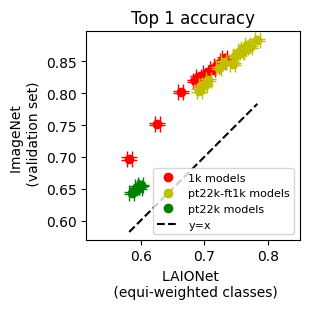

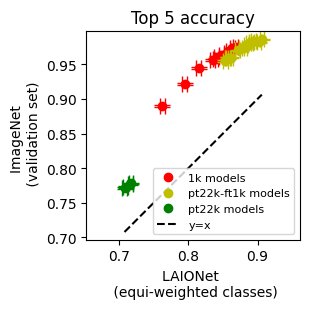

In [19]:
for top_k in [1, 5]:

    plt.figure(figsize=(3.2, 3.2))

    min_acc, max_acc = np.inf, -np.inf
    modelname2handle = {}
    for model_name in model_names:
        cl = modelname2color[model_name]

        acc = topk2model2acc[top_k][model_name]['acc']
        acc_se = topk2model2acc[top_k][model_name]['acc_se']

        h = plt.plot(acc, topk2model2ilsvrcacc[top_k][model_name]['acc'], 'o', color=cl)
        plt.errorbar(
            acc, 
            topk2model2ilsvrcacc[top_k][model_name]['acc'],
            xerr=acc_se*z, 
            yerr=topk2model2ilsvrcacc[top_k][model_name]['acc_se'],
            capsize=6,
            color=cl
        )

        min_acc = np.minimum(min_acc, acc)
        max_acc = np.maximum(max_acc, acc)

        modelname2handle[model_name] = h[0]


    h = plt.plot([min_acc, max_acc], [min_acc, max_acc], 'k--')

    plt.legend(
        handles=[
            modelname2handle[all_model_names_1k[0]],
            modelname2handle[all_model_names_pt21k_ft1k[0]],
            modelname2handle[all_model_names_21k[0]],
            h[0]
        ],
        labels=['1k models', 'pt22k-ft1k models', 'pt22k models', 'y=x'],
        loc='lower right',
        fontsize=8
    )

    plt.title(f'Top {top_k} accuracy')
    plt.xlabel('LAIONet \n (equi-weighted classes)')
    plt.ylabel('ImageNet \n (validation set)')

    plt.axis('equal')

    plt.tight_layout()

    plt.savefig(os.path.join('figs', 'top%d_equi-acc_vs_ilsvrc-val-acc_%s(tqsim%.2f).pdf' % (top_k, laionet_prefix, tq_sim_th)), bbox_inches='tight')
    

# Calc. relative frequency of the classes

## Load all labels (not skimmed)

In [20]:
all_laionet_prefix = configs.NamingConfig.append_filtered(configs.NamingConfig.SUBSET_SM_PREFIX, text_query_sim_col)
all_laionet_labels_file_name = f'wnid2laionindices({all_laionet_prefix}).pkl'

with open(os.path.join(laionet_labels_path, all_laionet_labels_file_name), 'rb') as f:
    all_wnid2laionindices = pickle.load(f)

## Calc. stats

In [21]:
n = np.sum([len(laion_indices) for _, laion_indices in all_wnid2laionindices.items()])

wnid2freq = {wnid: len(laion_indices) for wnid, laion_indices in all_wnid2laionindices.items() if len(laion_indices) > 0}

# Sort it by freq
wnid2freq = dict(sorted(wnid2freq.items(), key=lambda item: -item[1]))

# Find prob.
wnid2prob = {wnid: freq/n for wnid, freq in wnid2freq.items()}

In [22]:
wnids = list(wnid2freq.keys())

synsets = []
freqs = []
for wnid in wnids:
    synsets.append(wnu.get_synset(wnid).name().split('.n')[0])
    freqs.append(wnid2freq[wnid])

imagenet_tot = np.sum(freqs)

In [23]:
print('Out of roughly 400M LAION samples, %d (%.2f%%) of them have at least one ImageNet class.'
      % (imagenet_tot, imagenet_tot/4e8*100))

Out of roughly 400M LAION samples, 822149 (0.21%) of them have at least one ImageNet class.


## Plot freq.

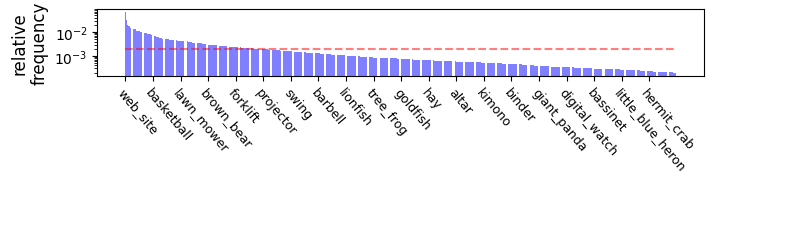

In [24]:
plt.figure(figsize=(8, 2.6))

freqs = freqs[:500]
synsets = synsets[:500]

n = len(freqs)

plt.bar(synsets, freqs/imagenet_tot, color='b', alpha=0.5)
plt.plot([0, n - 1], [1/n]*2, 'r--', alpha=0.5)

plt.ylabel('relative\nfrequency', fontsize=12)
# plt.xlabel('synsets (sampled)', fontsize=18)

plt.xticks(rotation=-50, ha='left', rotation_mode='anchor', fontsize=9)

ax = plt.gca()
xticks = ax.xaxis.get_major_ticks()
for i_x, xtick in enumerate(xticks):
    if i_x % 25 != 0:
        xtick.set_visible(False)
        
plt.yscale('log')

plt.tight_layout()

plt.savefig(os.path.join('figs', f'relative_freq_{all_laionet_prefix}(all).pdf'), bbox_inches='tight')

# Calc. LAION-weighted accuracy

In [25]:
# Sanity check
print(np.sum([prob for _, prob in wnid2prob.items()]))

1.0000000000000002


## Helper functions

In [26]:
def calc_laion_acc(mdl2wnid2recall, mdl2wnid2recallse, wnid2p):
    mdl2acc = {}
    mdl2nwnid = {}
    for model_name in model_names:
        recalls = []
        recallses = []
        weights = []
        for wnid, recall in mdl2wnid2recall[model_name].items():
            recalls.append(recall)
            recallses.append(mdl2wnid2recallse[model_name][wnid])
            weights.append(wnid2p.get(wnid, 0))

        recalls = np.array(recalls)
        recallses = np.array(recallses)
        weights = np.array(weights)

        acc, acc_se = combine_recalls(recalls, recallses, weights)

        mdl2acc[model_name] = {
            'acc': acc, 
            'acc_se': acc_se,
        }
        
        mdl2nwnid[model_name] = np.sum(~np.isnan(recalls))
            
    return mdl2acc, mdl2nwnid

## Plot LAION-weighted accuracy vs. equi-weighted accuracy

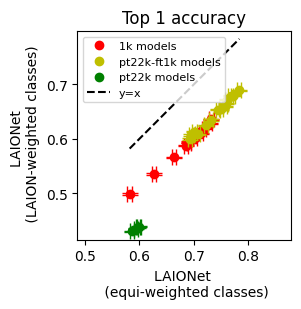

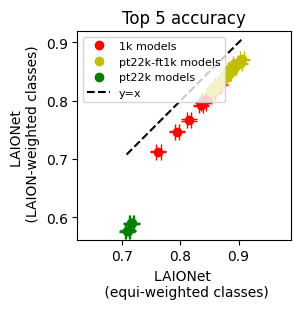

In [27]:
for top_k in [1, 5]:
    model2laionacc, _ = calc_laion_acc(topk2model2wnid2recall[top_k], topk2model2wnid2recallse[top_k], wnid2prob)

    plt.figure(figsize=(3.2, 3.2))

    min_acc, max_acc = np.inf, -np.inf
    modelname2handle = {}
    for model_name in model_names:
        cl = modelname2color[model_name]

        acc = topk2model2acc[top_k][model_name]['acc']
        acc_se = topk2model2acc[top_k][model_name]['acc_se']

        acc_laion = model2laionacc[model_name]['acc']
        acc_laion_se = model2laionacc[model_name]['acc_se']

        h = plt.plot(acc, acc_laion, 'o', color=cl)
        plt.errorbar(
            acc, 
            acc_laion,
            xerr=acc_se*z, 
            yerr=acc_laion_se*z,
            capsize=6,
            color=cl
        )

        min_acc = np.minimum(min_acc, acc)
        max_acc = np.maximum(max_acc, acc)

        modelname2handle[model_name] = h[0]


    h = plt.plot([min_acc, max_acc], [min_acc, max_acc], 'k--')

    plt.legend(
        handles=[
            modelname2handle[all_model_names_1k[0]],
            modelname2handle[all_model_names_pt21k_ft1k[0]],
            modelname2handle[all_model_names_21k[0]],
            h[0]
        ],
        labels=['1k models', 'pt22k-ft1k models', 'pt22k models', 'y=x'],
        loc='upper left',
        fontsize=8
    )

    plt.title(f'Top {top_k} accuracy')
    plt.xlabel('LAIONet \n (equi-weighted classes)')
    plt.ylabel('LAIONet \n (LAION-weighted classes)')

    plt.axis('equal')

    plt.tight_layout()

    plt.savefig(os.path.join('figs', 'top%d_natural-acc_vs_equi-acc_%s(tqsim%.2f).pdf' % (top_k, laionet_prefix, tq_sim_th)), bbox_inches='tight')
    

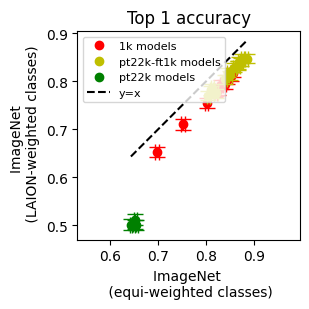

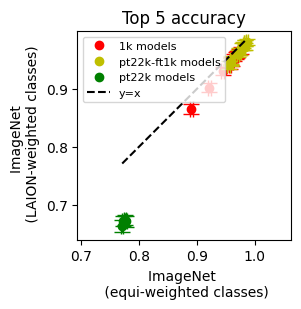

In [28]:
for top_k in [1, 5]:
    model2ilsvrclaionweightedacc, _ = \
    calc_laion_acc(topk2model2wnid2ilsvrcrecall[top_k], topk2model2wnid2ilsvrcrecallse[top_k], wnid2prob)

    plt.figure(figsize=(3.2, 3.2))

    min_acc, max_acc = np.inf, -np.inf
    modelname2handle = {}
    for model_name in model_names:
        cl = modelname2color[model_name]

        acc = topk2model2ilsvrcacc[top_k][model_name]['acc']
        acc_se = topk2model2ilsvrcacc[top_k][model_name]['acc_se']

        acc_laion = model2ilsvrclaionweightedacc[model_name]['acc']
        acc_laion_se = model2ilsvrclaionweightedacc[model_name]['acc_se']

        h = plt.plot(acc, acc_laion, 'o', color=cl)
        plt.errorbar(
            acc, 
            acc_laion,
            xerr=acc_se*z, 
            yerr=acc_laion_se*z,
            capsize=6,
            color=cl
        )

        min_acc = np.minimum(min_acc, acc)
        max_acc = np.maximum(max_acc, acc)

        modelname2handle[model_name] = h[0]


    h = plt.plot([min_acc, max_acc], [min_acc, max_acc], 'k--')

    plt.legend(
        handles=[
            modelname2handle[all_model_names_1k[0]],
            modelname2handle[all_model_names_pt21k_ft1k[0]],
            modelname2handle[all_model_names_21k[0]],
            h[0]
        ],
        labels=['1k models', 'pt22k-ft1k models', 'pt22k models', 'y=x'],
        loc='upper left',
        fontsize=8
    )

    plt.title(f'Top {top_k} accuracy')
    plt.xlabel('ImageNet \n (equi-weighted classes)')
    plt.ylabel('ImageNet \n (LAION-weighted classes)')

    plt.axis('equal')

    plt.tight_layout()

    plt.savefig(os.path.join('figs', 'top%d_ilsvrc_natural-acc_vs_equi-acc_%s(tqsim%.2f).pdf' % (top_k, laionet_prefix, tq_sim_th)), bbox_inches='tight')
    